In [17]:
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

import gmaps
import gmaps.datasets

In [18]:
def date_distribution(X, date_from, date_to, step = 'day', day_count = 1, by_blocks = False):
    neg = X[X['ttype'] == NEG_TWEET]
    pos = X[X['ttype'] == POS_TWEET]
    
    neg_date = neg[neg['tdate'] < date_to]
    pos_date = pos[pos['tdate'] < date_to]
    
    if step == 'minute':
        step = 60
    elif step == 'hour':
        step = 60*60
    elif step == 'day':
        step = 60*60*24*day_count
    elif step == 'week':
        step = 60*60*24*7
    
    pos_count = list()
    neg_count = list()
    
    dates_in_range = range(date_from, date_to, step)
    
    for date in dates_in_range:
        if by_blocks:
            pos_count.append(pos_date[(pos_date['tdate'] > date) & (pos_date['tdate'] < (date + step))].shape[0])
            neg_count.append(neg_date[(neg_date['tdate'] > date) & (neg_date['tdate'] < (date + step))].shape[0])
        else:
            pos_count.append(pos_date[pos_date['tdate'] < date].shape[0])
            neg_count.append(neg_date[neg_date['tdate'] < date].shape[0])
            
    
    dates_in_range = [datetime.datetime.fromtimestamp(d) for d in dates_in_range]
    return pos_count, neg_count, dates_in_range
    
def split_points(pnt):
    return tuple(map(float, pnt.split(','))) 

In [21]:
with open('maps_token.txt') as f:
    key = f.read()
    gmaps.configure(api_key=key)
    
NEG_TWEET = -1
POS_TWEET = 1

FIG_SIZE = (15, 6)

## Визуализация тренировочных твитов
Визуализируются следующие параметры:
* Сколько всего негативных и позитивных твитов от даты А до даты Б
* Сколько было позитивных/негативных твитов от даты А до даты Б по "блокам" (например, недели)

Даты в исходном датасете распределены неравномерно.

In [22]:
neg = pd.read_csv('data/train/negative.csv', sep=';')
pos = pd.read_csv('data/train/positive.csv', sep=';')

neg = neg.drop(['id', 'trep', 'tmane', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)

pos = pos.drop(['id', 'trep', 'tmane', 'trtw', 'tfav',
       'tstcount', 'tfrien', 'listcount', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'], axis=1)


X = pd.concat([pos, neg], ignore_index=True)

(735206.0, 735260.0, 0.0, 120000.0)

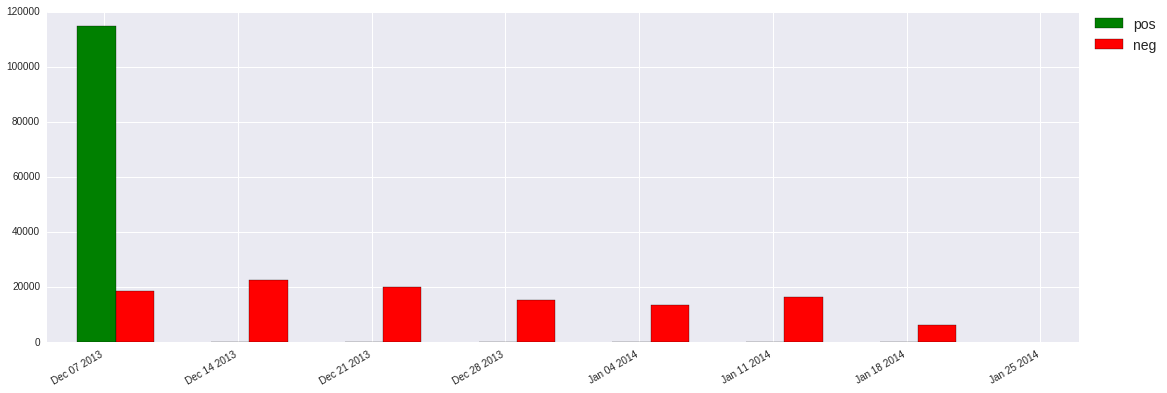

In [23]:
pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(),
                                                step = 'week', by_blocks = True)
dates = date2num(dates)

fig, ax = plt.subplots()
fig.set_size_inches(FIG_SIZE)

plt.tight_layout()

w = 2.
ax.bar(dates - w/2, pos_count, width=2, color = 'green', label = 'pos')
ax.bar(dates + w/2 , neg_count, width=2, color = 'red', label = 'neg')

ax.xaxis_date()

plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad = 0., fontsize=14)

#немного костылей
x0, x1, y0, y1 = plt.axis()
plt.axis((x0 + w*3, x1, y0, y1))

#ax.autoscale_view(False, True)

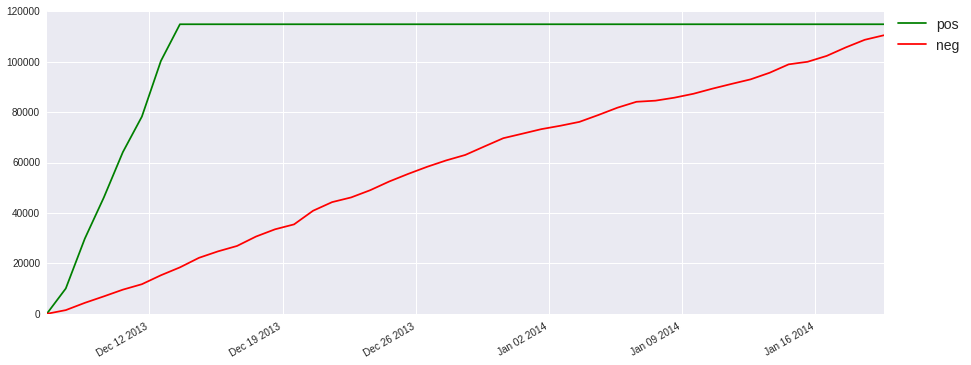

In [24]:
pos_count, neg_count, dates = date_distribution(X, X['tdate'].min(), X['tdate'].max(), step = 'day')
dates = date2num(dates)

fig, ax = plt.subplots()
fig.set_size_inches(FIG_SIZE)

plt.plot(dates, pos_count, color = 'green', label = 'pos')
plt.plot(dates, neg_count, color = 'red', label = 'neg')

ax.xaxis_date()
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad = 0., fontsize=14)

ax.autoscale_view(False, True)

## Визуализация твитов по ВУЗ'ам
Heatmap твитов, процент твитов с геотэгами маленький (примерно 1 твит на 50), поэтому карта не очень полно выглядит.
Необходимо авторизоваться т.к. используются google maps. API key для JS google maps API загружается из файла maps_token.txt

In [43]:
def get_heatmap(X):
    if X.shape[0] != 0:
        points = list(Tweets['tgeo'].apply(split_points))

        m = gmaps.Map()
        m.add_layer(gmaps.Heatmap(data=points))
        return m
    else:
        print 'There is no tweets with geotag!'

In [44]:
Tweets = pd.read_csv('data/old_tweets/MSU.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

In [45]:
Tweets = pd.read_csv('data/old_tweets/MIPT.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

In [47]:
Tweets = pd.read_csv('data/old_tweets/SPBU.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)

There is no tweets with geotag!


In [48]:
Tweets = pd.read_csv('data/old_tweets/ITMO.csv', sep=';', na_values='None').dropna()
get_heatmap(Tweets)